In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
import fastai
print("fastai: ",fastai.__version__)
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

fastai:  1.0.46
Torch:  1.0.1.post2
Torchvision:  0.2.1
sklearn:  0.20.2
Python:  3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [3]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

GPU:  GeForce GTX 1080 Ti


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [6]:
PATH = '../../../../../data/PetFinder/'

In [7]:
import os
print(os.listdir(PATH))

['breed_labels.csv', 'train.zip', 'train_sentiment.zip', 'test_metadata.zip', 'train', 'test.zip', 'test_sentiment.zip', 'train.csv', 'state_labels.csv', 'test', 'train_metadata.zip', 'train_images.zip', 'models', 'color_labels.csv', 'sample_submission.csv', 'test_images.zip', 'test.csv']


In [9]:
trainCSV = pd.read_csv(PATH+'train.csv')
trainCSV.head().T

0  \
Type                                                           2   
Name                                                      Nibble   
Age                                                            3   
Breed1                                                       299   
Breed2                                                         0   
Gender                                                         1   
Color1                                                         1   
Color2                                                         7   
Color3                                                         0   
MaturitySize                                                   1   
FurLength                                                      1   
Vaccinated                                                     2   
Dewormed                                                       2   
Sterilized                                                     2   
Health                                                         1   
Quantity                                                       1   
Fee                                                          100   
State                                                      41326   
RescuerID                       8480853f516546f6cf33aa88cd76c379   
VideoAmt                                                       0   
Description    Nibble is a 3+ month old ball of cuteness. He ...   
PetID                                                  86e1089a3   
PhotoAmt                                                       1   
AdoptionSpeed                                                  2   

                                                               1  \
Type                                                           2   
Name                                                 No Name Yet   
Age                                                            1   
Breed1                                                       265   
Breed2                                                         0   
Gender                                                         1   
Color1                                                         1   
Color2                                                         2   
Color3                                                         0   
MaturitySize                                                   2   
FurLength                                                      2   
Vaccinated                                                     3   
Dewormed                                                       3   
Sterilized                                                     3   
Health                                                         1   
Quantity                                                       1   
Fee                                                            0   
State                                                      41401   
RescuerID                       3082c7125d8fb66f7dd4bff4192c8b14   
VideoAmt                                                       0   
Description    I just found it alone yesterday near my apartm...   
PetID                                                  6296e909a   
PhotoAmt                                                       2   
AdoptionSpeed                                                  0   

                                                               2  \
Type                                                           1   
Name                                                      Brisco   
Age                                                            1   
Breed1                                                       307   
Breed2                                                         0   
Gender                                                         1   
Color1                                                         2   
Color2                                                         7   
Color3                                           

In [10]:
trainID = trainCSV[['PetID', 'AdoptionSpeed']].copy()
trainID.head()

PetID  AdoptionSpeed
0  86e1089a3              2
1  6296e909a              0
2  3422e4906              3
3  5842f1ff5              2
4  850a43f90              2

In [11]:
trainID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 2 columns):
PetID            14993 non-null object
AdoptionSpeed    14993 non-null int64
dtypes: int64(1), object(1)
memory usage: 234.3+ KB


In [12]:
trainID.describe()

AdoptionSpeed
count   14993.000000
mean        2.516441
std         1.177265
min         0.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         4.000000

0 - Pet was adopted on the same day as it was listed.
1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
4 - No adoption after 100 days of listed. (There are no pets in this dataset that waited between 90 and 100 days). 

In [13]:
classes = trainID['AdoptionSpeed'].value_counts()
classes

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

In [14]:
classes.shape, type(classes)

((5,), pandas.core.series.Series)

In [15]:
#check if target has any missing values
trainID['AdoptionSpeed'].isnull().values.any()

False

In [16]:
testCSV = pd.read_csv(PATH+'test.csv')
testCSV.head().T

0  \
Type                                                          1   
Name                                                      Puppy   
Age                                                           2   
Breed1                                                      307   
Breed2                                                        0   
Gender                                                        1   
Color1                                                        1   
Color2                                                        0   
Color3                                                        0   
MaturitySize                                                  2   
FurLength                                                     2   
Vaccinated                                                    2   
Dewormed                                                      2   
Sterilized                                                    2   
Health                                                        1   
Quantity                                                      1   
Fee                                                         150   
State                                                     41326   
RescuerID                      4475f31553f0170229455e3c5645644f   
VideoAmt                                                      0   
Description   Puppy is calm for a young dog, but he becomes ...   
PetID                                                 378fcc4fc   
PhotoAmt                                                      3   

                                                              1  \
Type                                                          2   
Name                                                     London   
Age                                                          24   
Breed1                                                      266   
Breed2                                                        0   
Gender                                                        1   
Color1                                                        2   
Color2                                                        7   
Color3                                                        0   
MaturitySize                                                  2   
FurLength                                                     1   
Vaccinated                                                    1   
Dewormed                                                      1   
Sterilized                                                    1   
Health                                                        1   
Quantity                                                      1   
Fee                                                           0   
State                                                     41326   
RescuerID                      4475f31553f0170229455e3c5645644f   
VideoAmt                                                      0   
Description   Urgently seeking adoption. Please contact for ...   
PetID                                                 73c10e136   
PhotoAmt                                                      1   

                                                              2  \
Type                                                          2   
Name                                                   Snowball   
Age                                                          20   
Breed1                                                      266   
Breed2                                                        0   
Gender                                                        2   
Color1                                                        7   
Color2                                                        0   
Color3                                                        0   
MaturitySize                                                  2   
FurLength                                                     1   
Vaccinated                              

In [17]:
testID = testCSV[['PetID']].copy()
testID.head()

PetID
0  378fcc4fc
1  73c10e136
2  72000c4c5
3  e147a4b9f
4  43fbba852

In [18]:
path_img = PATH + 'train'
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('../../../../../data/PetFinder/train/bec6cc26b-3.jpg'),
 PosixPath('../../../../../data/PetFinder/train/700a93465-1.jpg'),
 PosixPath('../../../../../data/PetFinder/train/052160ae6-1.jpg'),
 PosixPath('../../../../../data/PetFinder/train/1bff3e46f-6.jpg'),
 PosixPath('../../../../../data/PetFinder/train/b12e22341-1.jpg')]

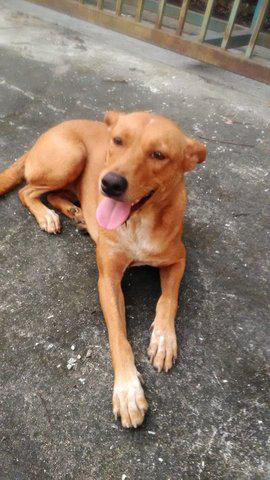

In [19]:
open_image('../../../../../data/PetFinder/train/bea72e6c5-1.jpg')

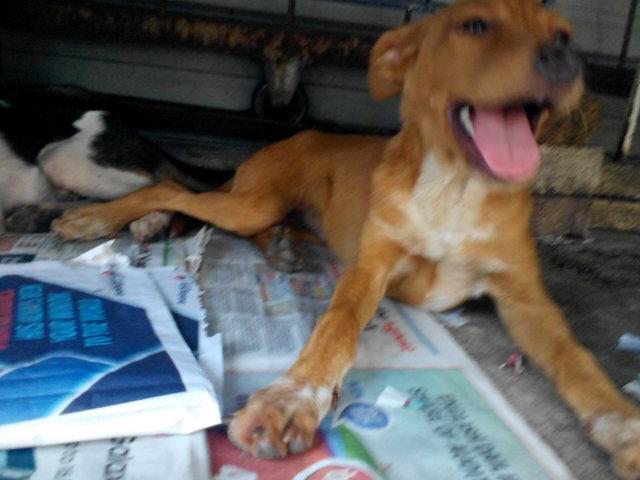

In [20]:
open_image('../../../../../data/PetFinder/train/bea72e6c5-2.jpg')

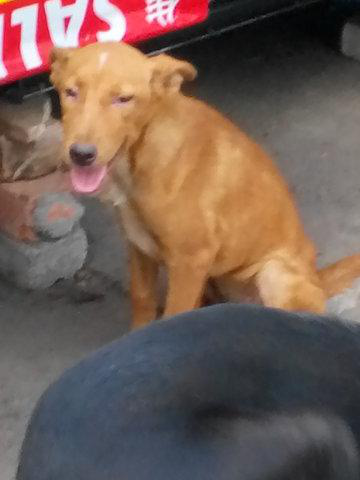

In [21]:
open_image('../../../../../data/PetFinder/train/bea72e6c5-4.jpg')

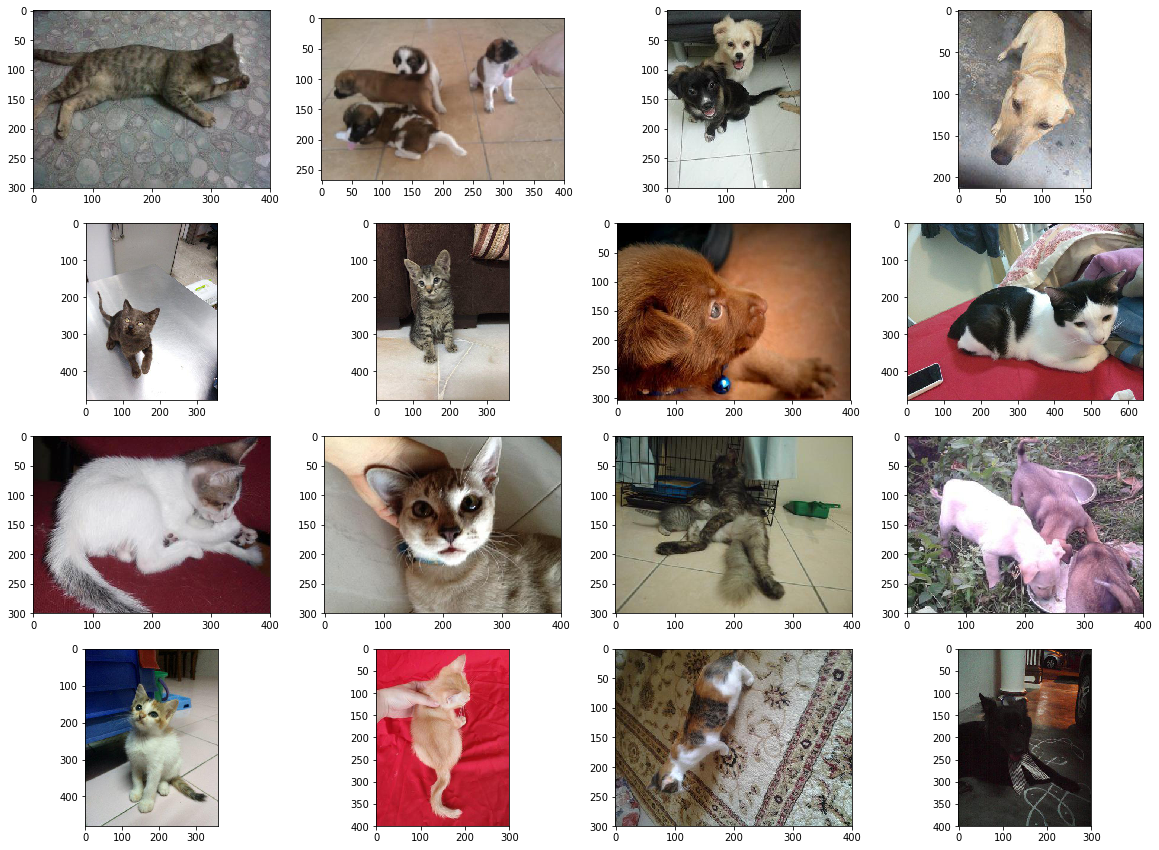

In [22]:
# print few images from train set
fig=plt.figure(figsize=(20, 15))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = plt.imread(fnames[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [23]:
# read image size
im=array([list(open_image(image).size) for image in fnames])
type(im)

numpy.ndarray

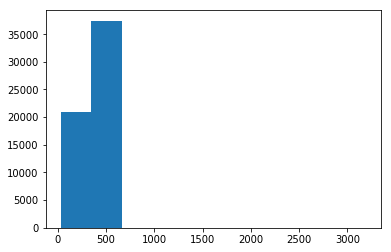

In [24]:
# histogram of x
plt.hist(im[:,0]);

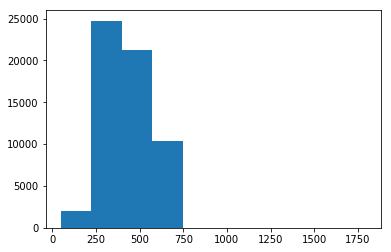

In [25]:
# histogram of y
plt.hist(im[:,1]);

In [26]:
tfms = get_transforms(do_flip=True)

In [27]:
#view image augmentations
def get_ex(): return open_image(fnames[0])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
     rows,cols,figsize=(width,height))[1].flatten())]

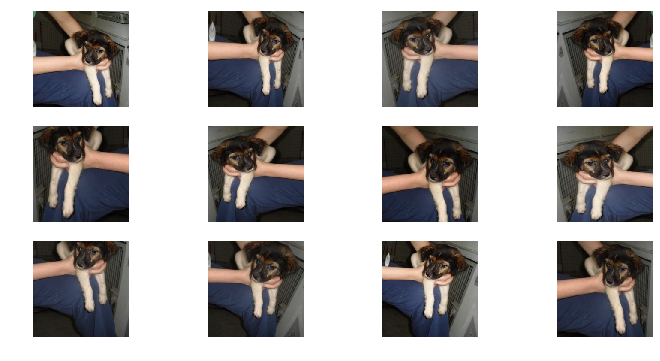

In [28]:
plots_f(3, 4, 12, 6, size=224)

In [38]:
trainID.head()

PetID  AdoptionSpeed
0  86e1089a3              2
1  6296e909a              0
2  3422e4906              3
3  5842f1ff5              2
4  850a43f90              2

In [39]:
#pattern to parse full file path+name
# group(0) - file name with index and jpg extension
# group(1) - file name with index but without jpg extension
# group(2) - file name without index nor jpeg extension
# group(3) - file name index number
pat = r"(([\w\.-]+)-(\d+))\.jpg"
pat = re.compile(pat)
pat

re.compile(r'(([\w\.-]+)-(\d+))\.jpg', re.UNICODE)

In [40]:
#test and verify re parsing pattern
res = pat.search("../../../../../data/PetFinder/train/8d6c8d486-10.jpg")
res.group(0), res.group(1), res.group(2), res.group(3)

('8d6c8d486-10.jpg', '8d6c8d486-10', '8d6c8d486', '10')

In [41]:
#create new empty DataFrame for each File image in the row and copied Adption Speed value
NewList =  pd.DataFrame(columns=["PetID","AdoptionSpeed"])
NewList

Empty DataFrame
Columns: [PetID, AdoptionSpeed]
Index: []

In [42]:
# Loop through every file name, find match in Train Target DataFrame, extract Adoption Speed value, and 
# append new row into NewList DataFrame
for name in fnames:
    #parse file path+name
    res = pat.search(str(name))
    #print("core name: ", res.group(2))      #file_core = res.group(2)
    if ((trainID['PetID']==res.group(2)).values.any()): #if fname core is found in dataframe with PetID,AdoptionTime
            AdoptionSpeed=trainID[trainID['PetID']==res.group(2)].AdoptionSpeed.values[0] #extract Adoption Time
            #copy row into new Data Frame
            NewList = NewList.append(pd.DataFrame({"PetID":[res.group(1)], "AdoptionSpeed":[AdoptionSpeed] }),ignore_index = True)

In [43]:
NewList.head()

PetID AdoptionSpeed
0  bec6cc26b-3             1
1  700a93465-1             2
2  052160ae6-1             1
3  1bff3e46f-6             4
4  b12e22341-1             4

In [44]:
data = ImageDataBunch.from_df(PATH, NewList, folder='train', ds_tfms=tfms, size=224, suffix='.jpg')

In [45]:
#Number of files
len(fnames)

58311

In [46]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (46649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,4,2,2
Path: ../../../../../data/PetFinder;

Valid: LabelList (11662 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,4,3,3,4
Path: ../../../../../data/PetFinder;

Test: None

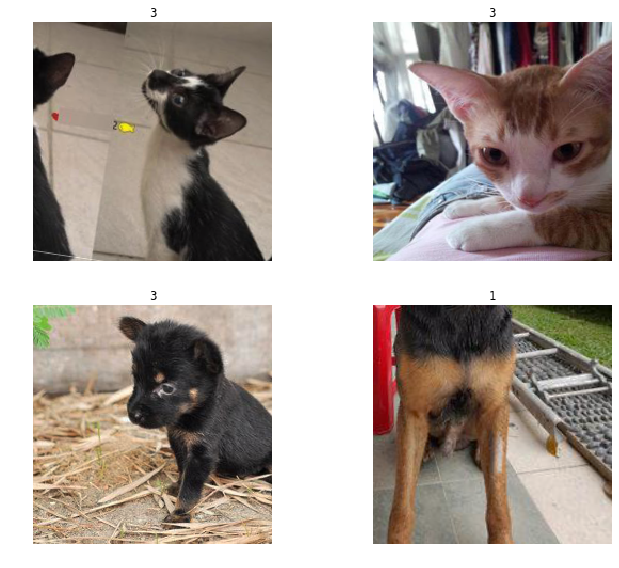

In [47]:
#show few images from data set with Adoptoin Speed as class above
data.show_batch(rows=2, figsize=(10,8), ds_type=DatasetType.Train)

In [48]:
#list data classes
print(data.classes)
len(data.classes)

[0, 1, 2, 3, 4]


5

In [49]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [50]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [51]:
learn.fit_one_cycle(5)

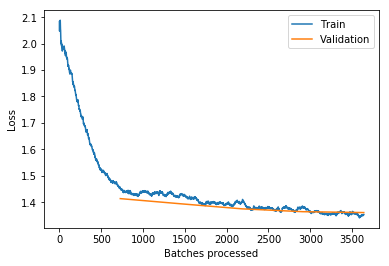

In [52]:
learn.recorder.plot_losses()

In [53]:
learn.save('224_pre')

In [54]:
learn.load('224_pre');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


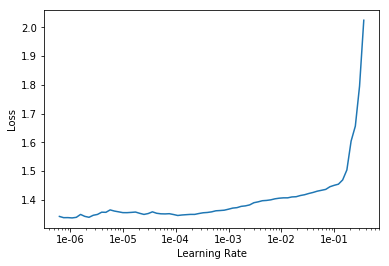

In [55]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

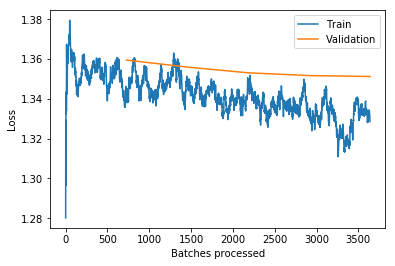

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.save('224_all')

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

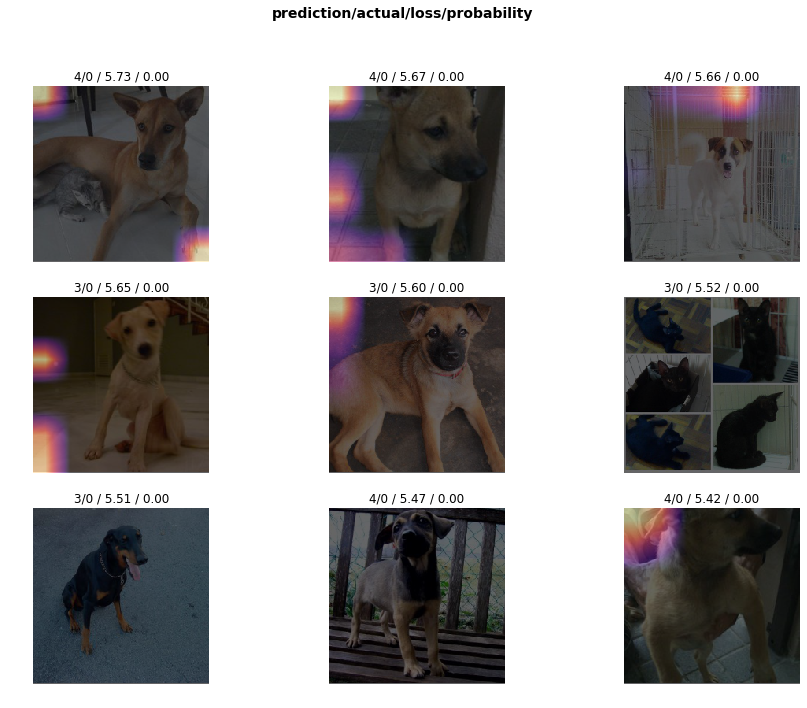

In [60]:
interp.plot_top_losses(9, figsize=(15,11))

In [61]:
# Run second itteration with size = 299
data = ImageDataBunch.from_df(PATH, NewList, folder='train', ds_tfms=tfms, size=299, suffix='.jpg')
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (46649 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,2,1,4,2
Path: ../../../../../data/PetFinder;

Valid: LabelList (11662 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
4,3,3,2,1
Path: ../../../../../data/PetFinder;

Test: None

In [ ]:
learn.data = data
data.train_ds[0][0].shape

In [62]:
# preload last weights
learn.load('224_all')

Learner(data=ImageDataBunch;

Train: LabelList (46649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,4,2,2
Path: ../../../../../data/PetFinder;

Valid: LabelList (11662 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,4,3,3,4
Path: ../../../../../data/PetFinder;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


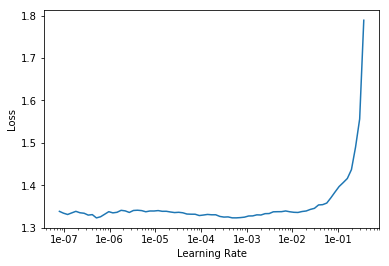

In [63]:
learn.freeze()
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(5, max_lr=1e-4)

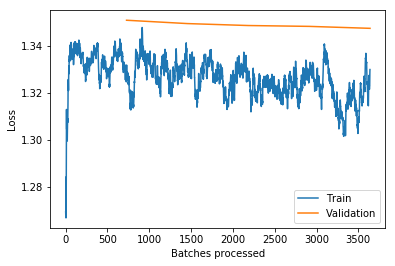

In [65]:
learn.recorder.plot_losses()

In [66]:
learn.save('299_pre')

In [67]:
learn.load('299_pre')

Learner(data=ImageDataBunch;

Train: LabelList (46649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,4,2,2
Path: ../../../../../data/PetFinder;

Valid: LabelList (11662 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,4,3,3,4
Path: ../../../../../data/PetFinder;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


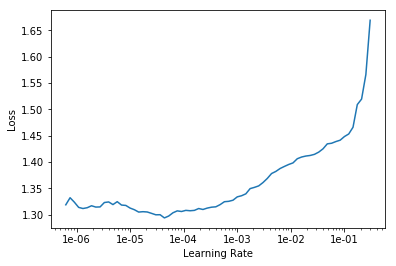

In [68]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(6, max_lr=slice(1e-7,2e-6))

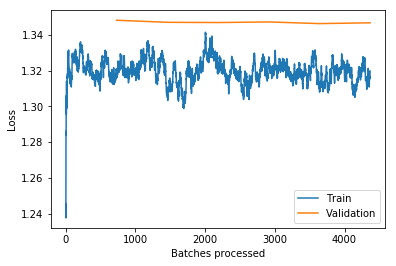

In [70]:
learn.recorder.plot_losses()

In [71]:
learn.save('299_all')

In [72]:
learn.export()
learn.path

PosixPath('../../../../../data/PetFinder')

In [73]:
# testing DataFrame
test = ImageList.from_folder(PATH+'test')
len(test)

15040

In [77]:
learn = load_learner(path=learn.path, test=test)

In [79]:
learn.data.test_ds.items

array([PosixPath('../../../../../data/PetFinder/test/7da0b6748-3.jpg'),
       PosixPath('../../../../../data/PetFinder/test/c40b151c9-1.jpg'),
       PosixPath('../../../../../data/PetFinder/test/053553ce4-6.jpg'),
       PosixPath('../../../../../data/PetFinder/test/27e7d47b6-8.jpg'), ...,
       PosixPath('../../../../../data/PetFinder/test/9dbaf8a68-6.jpg'),
       PosixPath('../../../../../data/PetFinder/test/c98ae5256-1.jpg'),
       PosixPath('../../../../../data/PetFinder/test/505037d6d-11.jpg'),
       PosixPath('../../../../../data/PetFinder/test/a0b6f1501-1.jpg')], dtype=object)

In [134]:
learn.data.test_ds.items[5]

PosixPath('../../../../../data/PetFinder/test/36db59fdd-4.jpg')

In [88]:
learn.data.test_dl.device

device(type='cuda')

In [80]:
learn.data.test_ds

LabelList (15040 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ../../../../../data/PetFinder

In [81]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [125]:
# find highest probability 
Prediction = preds.argmax(dim=1)
Prediction = Prediction.numpy().tolist()
Prediction[:10]

[4, 1, 2, 4, 2, 2, 2, 3, 2, 1]

In [104]:
Prediction.shape

torch.Size([15040])

In [195]:
submission = pd.read_csv(PATH+'sample_submission_original.csv')
submission.head()

PetID  AdoptionSpeed
0  378fcc4fc              0
1  73c10e136              0
2  72000c4c5              0
3  e147a4b9f              0
4  43fbba852              0

In [167]:
submission.PetID[0]

'378fcc4fc'

In [190]:
import statistics
import math

In [200]:
# Iterate DataFrame for each index and row (index and value)
for index, PetID in submission.iterrows():
    #print(index, PetID.values[0])  #extract Submission index and PetID core
    
    #find indices of all files in fnames that match PetID core name
    indices = [i for i, s in enumerate(fnames) if PetID.values[0] in s]  
    #print(indices)
    PetIdPredictions = [Prediction[i] for i in indices] # get list of predictions with given indeces
    #print(PetIdPredictions)
    if( len(PetIdPredictions) == 0):
        #print("? ",index, indices, PetID.values[0])
        FinalPrediction=4 # set to most common class
    else:
        FinalPrediction=math.ceil(statistics.median([Prediction[i] for i in indices])) #median with rounding up
    #print(FinalPrediction)
    submission.AdoptionSpeed[index] = FinalPrediction
    

/home/norvilr/anaconda3/envs/fastai1.0.42/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


?  96 [] a0b3ccddc
?  154 [] 335c29a28
?  230 [] f6b750fa0
?  234 [] 5882f07fa
?  251 [] 7950faa64
?  332 [] eea05de84
?  424 [] e46215f44
?  485 [] 1be0db8e9
?  677 [] 370280ff2
?  684 [] eb44980b8
?  803 [] 62b065db7
?  850 [] 267df54a7
?  984 [] b661e13c8
?  1010 [] c3868c29d
?  1068 [] bcccc164a
?  1276 [] d7fd89f97
?  1301 [] abaef4874
?  1444 [] 8f627a741
?  1445 [] 238ed0a35
?  1578 [] 740afa71d
?  1585 [] 102cca700
?  1586 [] 894aee840
?  1594 [] 37a1dfb06
?  1638 [] 548dda704
?  1719 [] ac8a06538
?  1843 [] 2a17e8f4f
?  1895 [] abd7a3644
?  1912 [] 17b6af953
?  1940 [] 07b908a27
?  1968 [] ced9a6c48
?  1975 [] 6818b2d64
?  1987 [] 1eea05736
?  1999 [] e0289dee8
?  2060 [] bc9558ff2


KeyboardInterrupt: 

In [ ]:
submission.head()

In [ ]:
submission.to_csv(PATH+'sample_submission.csv', index=False)

In [202]:
# find same pet based on core filen name in test dataSet
indices = [i for i, s in enumerate(fnames) if 'a0b3ccddc' in s]
indices

[]

In [ ]:
fnames[]

In [119]:
# Extract file names wthout .jpg extension and path
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
fnames[:10]

['7da0b6748-3',
 'c40b151c9-1',
 '053553ce4-6',
 '27e7d47b6-8',
 '1333e803a-16',
 '36db59fdd-4',
 '023572703-2',
 '4b047a13d-1',
 '1b848cdf5-1',
 '305d685bf-1']

In [186]:
# find same pet based on core filen name in test dataSet
indices = [i for i, s in enumerate(fnames) if submission.PetID[0] in s]
indices


[608, 8277, 12451]

In [187]:
[Prediction[i] for i in indices]

[2, 2, 2]

In [169]:
len(indices)

3

In [183]:
#Extract predictions of same pet but different images
predictionsList = []
for i in range(0,len(indices)):
    print(indices[i], " - ", Prediction[indices[i]])
    predictionsList.append(Prediction[indices[i]])
print(predictionsList)

6803  -  3
11885  -  3
[3, 3]


In [180]:
a = [2]
a

[2]

In [181]:
import statistics
import math
print(statistics.mean(a))
print(statistics.median(a))
print(math.ceil(statistics.median(a)))


2
2
2


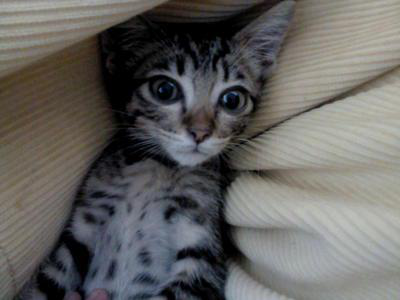

In [201]:
open_image(learn.data.test_ds.items[96])

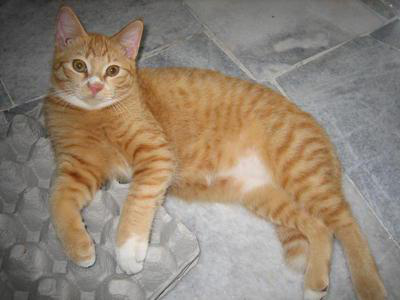

In [136]:
open_image(learn.data.test_ds.items[7317])

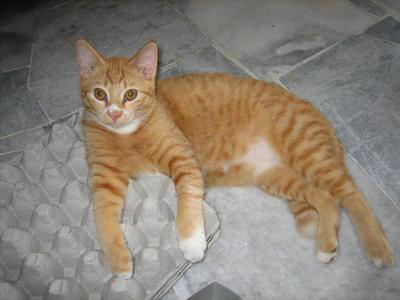

In [137]:
open_image(learn.data.test_ds.items[12499])

In [85]:
preds.

<bound method Tensor.argmax of tensor([[0.0113, 0.0861, 0.1968, 0.2475, 0.4583],
        [0.1239, 0.3730, 0.3146, 0.1323, 0.0561],
        [0.0409, 0.2459, 0.2838, 0.1779, 0.2514],
        ...,
        [0.0152, 0.2536, 0.2882, 0.1764, 0.2666],
        [0.0039, 0.0331, 0.1660, 0.3840, 0.4131],
        [0.0286, 0.1635, 0.2606, 0.2978, 0.2495]])>

## Testintg Data Processing

In [226]:
# create a mini dataFrame for testing
aa = trainID[:10].copy()
aa


PetID  AdoptionSpeed
0  86e1089a3              2
1  6296e909a              0
2  3422e4906              3
3  5842f1ff5              2
4  850a43f90              2

In [223]:
# Iterate DataFrame for each index and row (index and value)
for index, row in aa.iterrows():
    print(row.index[0], row.values[0])
    print(row.index[1], row.values[1])
    

<class 'pandas.core.series.Series'>
PetID 86e1089a3-1
AdoptionSpeed 2
<class 'pandas.core.series.Series'>
PetID 6296e909a
AdoptionSpeed 0
<class 'pandas.core.series.Series'>
PetID 3422e4906
AdoptionSpeed 3
<class 'pandas.core.series.Series'>
PetID 5842f1ff5
AdoptionSpeed 2
<class 'pandas.core.series.Series'>
PetID 850a43f90
AdoptionSpeed 2


In [172]:
# find and replace specific dataFrame value
aa=aa.replace(to_replace="86e1089a3", value="86e1089a3-1")
aa.head()

PetID  AdoptionSpeed
0  86e1089a3-1              2
1    6296e909a              0
2    3422e4906              3
3    5842f1ff5              2
4    850a43f90              2

In [248]:
# find Dataframe row with matching 'PetID' value
aa[aa['PetID']=="5842f1ff5"]

PetID  AdoptionSpeed
566  700a93465              2

In [186]:
# check if such PetID exists in DataFrame
(aa['PetID']=='8d6c8d486').values.any()

True

In [187]:
# print DataFrame row with specific PetID
aa[aa['PetID']=='8d6c8d486']

PetID  AdoptionSpeed
3310  8d6c8d486              3

In [232]:
# extract index and AdoptionSpeed value from matching PetID
clas=trainID[trainID['PetID']=='8d6c8d486'].AdoptionSpeed
print(clas.index[0], clas.values[0])

(3310, array(['8d6c8d486', 3], dtype=object))

In [132]:
# if file name was a class, then 'ImageDataBunch.from_name_re' could be used 

pat = r"(([\w\.-]+)-(\d+))\.jpg"
pat = re.compile(pat)
pat

re.compile(r'(([\w\.-]+)-(\d+))\.jpg', re.UNICODE)

In [67]:
#res = pat.search(str(fnames[0]))
res = pat.search("../../../../../data/PetFinder/train/8d6c8d486-10.jpg")
res.group(0), res.group(1), res.group(2), res.group(3)

('8d6c8d486-10.jpg', '8d6c8d486-10', '8d6c8d486', '10')

In [311]:
data = ImageDataBunch.from_name_re(PATH, fnames, pat=pat, ds_tfms=tfms, size=224)

/home/norvilr/anaconda3/envs/fastai1.0.42/lib/python3.7/site-packages/fastai/data_block.py:498: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
e8d0eedf7, 46fdbf640, fe7e662c5, d7c0647d0, 03c6478b9...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [312]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (46649 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
700a93465,052160ae6,1bff3e46f,b12e22341,0d2394669
Path: ../../../../../data/PetFinder;

Valid: LabelList (10741 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
492fe3371,9c91ae76a,80bbb481b,473af1ce7,fc5e81c00
Path: ../../../../../data/PetFinder;

Test: None

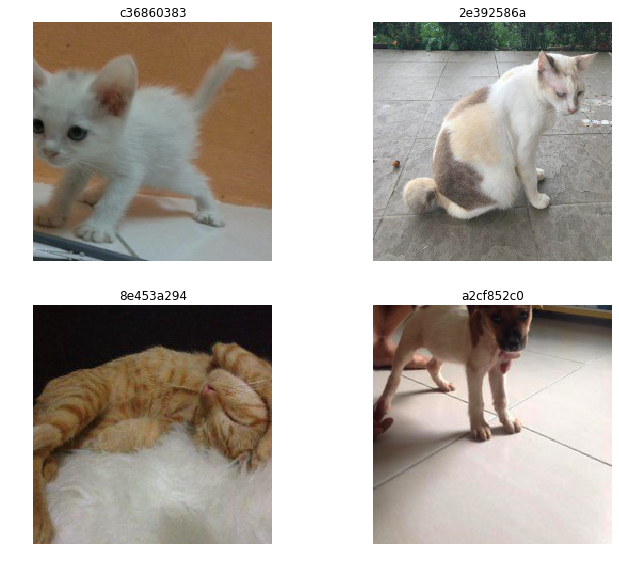

In [313]:
data.show_batch(rows=2, figsize=(10,8), ds_type=DatasetType.Train)

In [309]:
len(data.classes)

13912